In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sp-500-stocks:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1807380%2F8510224%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240525%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240525T223619Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6669e8b32c2dd45972accf3bfb9a9b7d00b5e1ba2482d420767a5a8ebe3c19a44e5d16199b7766619ca523fdb9cb914264e6df26dca9c46555a5e563f877d7b8fca54495db46c8f7e20b4ae6b631fa702bd0e4def63eb3bd95a51d02e82da3fb4c22ddf2dc3f2c2beb7c64abd0321524e6309b1183d5828a04f6be07d71cd57975901d3d8a7128305f6a889dd11005a2bc577847d66a71da3770d73ab39100943d022e3fbf4f345a568295a9645f6b3925dbbaa1b725307b2ec2001040f88c261e8936c544b8f833fd85a4e891b49d74382b410f76586bc116759eea7c79173c2d5756bd7ca54bc6b6d9db65dc5dc21611b9939a8ae97d51211c3a29f067e75f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 44959712 bytes downloaded
Downloaded and uncompressed: sp-500-stocks
Data source import complete.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sp-500-stocks/sp500_companies.csv
/kaggle/input/sp-500-stocks/sp500_stocks.csv
/kaggle/input/sp-500-stocks/sp500_index.csv


### Predicting Future Stock Prices

The goal is to create a supervised learning model, preferably using Long Short-Term Memory (LSTM) neural
networks, to predict the future stock prices of S&P 500 companies. This involves using historical stock price
and market index data to train the model, means in this the model will be trained on historical data consisting of
various features like date, S&P index values, adjusted close, volume etc. which will then be used to make
predictions and to learn the patterns and relationships on future stock prices for the companies in the S&P 500
index.

I have focused on clean and visulizing the datasets in this version of proposal.

**Importing data from Kaggle, we have three data sets.**
https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks?resource=download

In [84]:
import pandas as pd
df_company = pd.read_csv('/kaggle/input/sp-500-stocks/sp500_companies.csv')
df_index = pd.read_csv('/kaggle/input/sp-500-stocks/sp500_index.csv')
df_stocks = pd.read_csv('/kaggle/input/sp-500-stocks/sp500_stocks.csv')





### **1. Data Overview and pre-processing**

We have three dataframes which contain


*   df_company = Company metadata for S&P 500 companies.
*   df_index = S&P index value each day
*   df_stocks = Individual stock features such as Date, Symbol, Adj Close, Close, High, Low, Open


Below we have looked at info from each of the data frame.

In [85]:
df_company.info()
print("\n")
df_index.info()
print("\n")
df_stocks.info()
print("\n")
df_stocks

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Exchange             503 non-null    object 
 1   Symbol               503 non-null    object 
 2   Shortname            503 non-null    object 
 3   Longname             503 non-null    object 
 4   Sector               503 non-null    object 
 5   Industry             503 non-null    object 
 6   Currentprice         503 non-null    float64
 7   Marketcap            503 non-null    int64  
 8   Ebitda               474 non-null    float64
 9   Revenuegrowth        502 non-null    float64
 10  City                 503 non-null    object 
 11  State                483 non-null    object 
 12  Country              503 non-null    object 
 13  Fulltimeemployees    496 non-null    float64
 14  Longbusinesssummary  503 non-null    object 
 15  Weight               503 non-null    flo

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,40.553387,69.414719,69.774246,69.122070,69.473244,3640265.0
1,2010-01-05,MMM,40.299381,68.979935,69.590302,68.311035,69.230766,3405012.0
2,2010-01-06,MMM,40.870903,69.958191,70.735786,69.824417,70.133781,6301126.0
3,2010-01-07,MMM,40.900215,70.008362,70.033447,68.662209,69.665550,5346240.0
4,2010-01-08,MMM,41.188412,70.501671,70.501671,69.648827,69.974915,4073337.0
...,...,...,...,...,...,...,...,...
1822364,2024-05-20,ZTS,174.389999,174.389999,174.710007,172.190002,173.589996,2254400.0
1822365,2024-05-21,ZTS,172.789993,172.789993,175.779999,172.520004,173.470001,1600400.0
1822366,2024-05-22,ZTS,172.050003,172.050003,173.979996,170.990005,172.020004,1575700.0
1822367,2024-05-23,ZTS,170.899994,170.899994,172.509995,169.729996,172.020004,1946000.0


Based on the info of dataframe df_company have 503 entries, below columns have null rows.

*   Ebitda
*   Revenuegrowth
*   State
*   Fulltimeemployees




**Dropping 'State', 'Fulltimeemployees' Column entirely** - I am not going to use   "State" and "Fulltimeemployees" column for future stock price prediction.


Dataframe's df_index and df_stocks don't have null rows.






In [86]:

df_company = df_company.drop(['State'], axis=1)
df_company = df_company.drop(['Fulltimeemployees'], axis=1)
df_company

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,Country,Longbusinesssummary,Weight
0,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,430.16,3197082271744,1.251820e+11,0.170,Redmond,United States,Microsoft Corporation develops and supports so...,0.064629
1,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,189.98,2913172193280,1.296290e+11,-0.043,Cupertino,United States,"Apple Inc. designs, manufactures, and markets ...",0.058890
2,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,1064.69,2618956185600,4.927500e+10,2.621,Santa Clara,United States,NVIDIA Corporation provides graphics and compu...,0.052942
3,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,174.99,2171083423744,1.097230e+11,0.154,Mountain View,United States,Alphabet Inc. offers various products and plat...,0.043888
4,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,176.33,2168841437184,1.097230e+11,0.154,Mountain View,United States,Alphabet Inc. offers various products and plat...,0.043843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,NMS,ETSY,"Etsy, Inc.","Etsy, Inc.",Consumer Cyclical,Internet Retail,60.62,7088478208,4.262970e+08,0.008,Brooklyn,United States,"Etsy, Inc., together with its subsidiaries, op...",0.000143
499,NYQ,IVZ,Invesco Ltd,Invesco Ltd.,Financial Services,Asset Management,15.63,7030858752,9.988000e+08,0.040,Atlanta,United States,Invesco Ltd. is a publicly owned investment ma...,0.000142
500,NYQ,RHI,Robert Half Inc.,Robert Half Inc.,Industrials,Staffing & Employment Services,66.55,6983291392,4.228020e+08,-0.140,Menlo Park,United States,Robert Half Inc. provides talent solutions and...,0.000141
501,NYQ,NCLH,Norwegian Cruise Line Holdings,Norwegian Cruise Line Holdings Ltd.,Consumer Cyclical,Travel Services,16.00,6864655872,2.055861e+09,0.203,Miami,United States,"Norwegian Cruise Line Holdings Ltd., together ...",0.000139


Revenue growth for Western Digital Corporation is missing. Western Digital had revenue of $11.26B in the twelve months ending March 31, 2024, down -15.97% year-over-year.
https://stockanalysis.com/stocks/wdc/revenue/

Revenue growth for Philip Morris International Inc. is missing. It had revenue of $35.95B in the twelve months ending March 31, 2024, up 12.21% year-over-year.
Adding this data to the dataframe.
https://stockanalysis.com/stocks/pm/revenue/

In [87]:
df_company[df_company['Revenuegrowth'].isnull()]

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,Country,Longbusinesssummary,Weight
313,NMS,WDC,Western Digital Corporation,Western Digital Corporation,Technology,Computer Hardware,74.81,24427333632,-396000000.0,NaN,San Jose,United States,"Western Digital Corporation develops, manufact...",0.000494


In [88]:
df_company.loc[df_company['Symbol']== 'WDC', 'Revenuegrowth']= [-0.1597]
# df_company.loc[df_company['Symbol']== 'PM', 'Revenuegrowth']= [0.1221]
df_company[df_company['Revenuegrowth'].isnull()]

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,Country,Longbusinesssummary,Weight


### **2. Data Visualization**

*   **Top 10 companies in Market Cap**

In order to list the top 10 companies in market cap we sort the data by market cap. Market cap is calculated by multiplying the current stock price by the total number of outstanding shares. This ranking reflects the collective perception of investors regarding the size, stability, and growth potential of these companies.

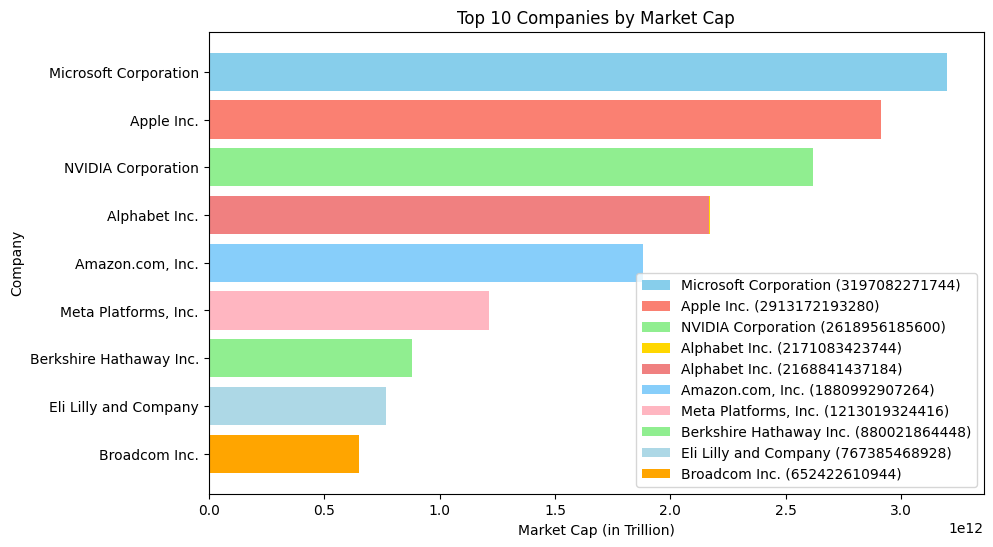

In [89]:
import matplotlib.pyplot as plt

sorted_data = df_company.sort_values(by='Marketcap', ascending=False)
top_10_data = sorted_data.head(10)

companies = top_10_data['Longname']
symbols = top_10_data['Symbol']
market_caps = top_10_data['Marketcap']


colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'lightcoral', 'lightskyblue', 'lightpink', 'lightgreen', 'lightblue', 'orange']


plt.figure(figsize=(10, 6))
bars = plt.barh(companies, market_caps, color=colors)
plt.xlabel('Market Cap (in Trillion)')
plt.ylabel('Company')
plt.title('Top 10 Companies by Market Cap')
plt.gca().invert_yaxis()

legend_labels = [f'{companies[i]} ({market_caps[i]})' for i in range(len(companies))]
plt.legend(bars, legend_labels, loc='lower right')

plt.show()

top_10_data.to_csv('top_10_companies_by_marketcap.csv', index=False)

[link text](https://)

*   **Time series chart of S&P 500**

Plotting a time series chart of the S&P 500 index provides a visual representation of the historical performance and trends of the stock market. This visualization is crucial for making informed decisions, identifying market cycles, detecting potential opportunities or risks, and assessing the effectiveness of investment strategies.

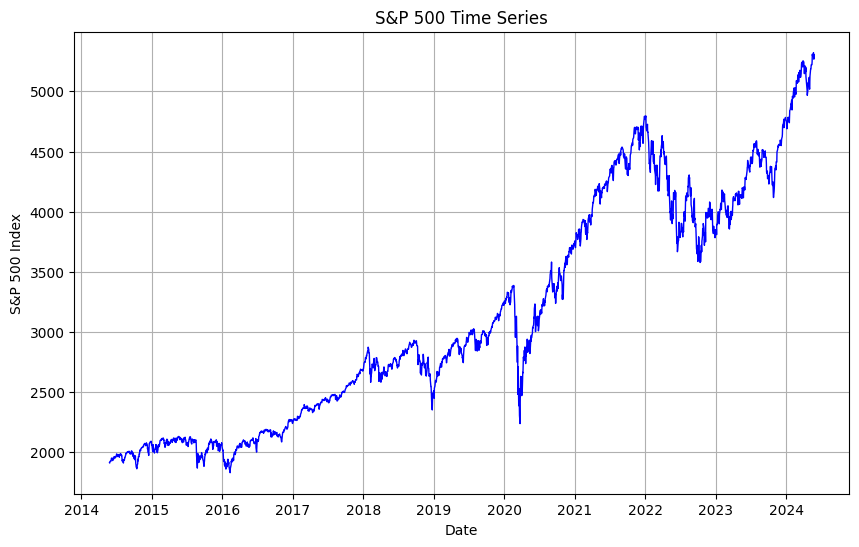

In [90]:
import matplotlib.pyplot as plt


df_index['Date'] = pd.to_datetime(df_index['Date'])

df_index.set_index('Date', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_index.index, df_index['S&P500'], color='blue', linewidth=1)
plt.title('S&P 500 Time Series')
plt.xlabel('Date')
plt.ylabel('S&P 500 Index')
plt.grid(True)
plt.show()



**Correlation between S&P 500 and its top 10 companies by Market Cap**
The S&P 500 is a benchmark index for the U.S. stock market, comprising 500 large-cap companies. The correlation between the S&P 500 and its top 10 companies by market capitalization shows how closely the index tracks the performance of these major players. When the top 10 companies experience price changes, it tends to influence the overall movement of the S&P 500 index.

In [23]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Ensure 'Date' is in datetime format and set it as the index
# df_index['Date'] = pd.to_datetime(df_index['Date'])
# df_index.set_index('Date', inplace=True)

# # Use a predefined style for a cleaner aesthetic
# plt.style.use('ggplot')

# # Create a figure and plot
# plt.figure(figsize=(12, 7))  # Increased figure size for better visibility
# plt.plot(df_index.index, df_index['S&P500'], color='royalblue', linewidth=2)  # Smoother and thicker line
# plt.title('S&P 500 Time Series', fontsize=16, fontweight='bold')
# plt.xlabel('Date', fontsize=14)
# plt.ylabel('S&P 500 Index', fontsize=14)
# plt.grid(True, linestyle='--', linewidth=0.5)  # Lighter grid
# plt.tick_params(axis='both', which='major', labelsize=12)

# # Enhance the x-axis to handle datetime formatting better
# plt.gcf().autofmt_xdate()  # Auto format the date labels for better fitting
# plt.show()


In [24]:

# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np


# df_index.reset_index(inplace=True)

# # Convert 'Date' columns to datetime objects
# df_stocks['Date'] = pd.to_datetime(df_stocks['Date'])

# # Merge the two datasets on the 'Date' column
# merged_df = pd.merge(df_index, df_stocks, on='Date', how='inner')


# filtered_df = merged_df[merged_df['Symbol'].isin(symbols)]

# # Calculate correlation
# correlation = filtered_df.groupby('Symbol')[['S&P500', 'Adj Close']].corr().iloc[0::2,-1].reset_index(level=1, drop=True)
# print("Correlation between S&P 500 and Adj Close for symbols MSFT and AAPL:")
# print(correlation)


# # Plotting scatterplots for each symbol
# for symbol in symbols:

#     symbol_data = merged_df[merged_df['Symbol'] == symbol]
#     correlation_coefficient = symbol_data['S&P500'].corr(symbol_data['Adj Close'])

#     plt.figure(figsize=(8, 5))
#     plt.scatter(symbol_data['S&P500'], symbol_data['Adj Close'], alpha=0.5)

#     # Add correlation line
#     x = symbol_data['S&P500']
#     y = symbol_data['Adj Close']
#     m, b = np.polyfit(x, y, 1)
#     plt.plot(x, m*x + b, color='red', label=f'Correlation Coefficient: {correlation_coefficient:.2f}')

#     plt.title(f'Scatterplot for {symbol}')
#     plt.xlabel('S&P500')
#     plt.ylabel('Adj Close')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

Correlation between S&P 500 and top 10 market cap companies:
Symbol
AAPL     0.968999
AMZN     0.914946
AVGO     0.896794
BRK-B    0.964513
GOOG     0.985827
GOOGL    0.985293
LLY      0.844422
META     0.862890
MSFT     0.984055
NVDA     0.828970
Name: Adj Close, dtype: float64


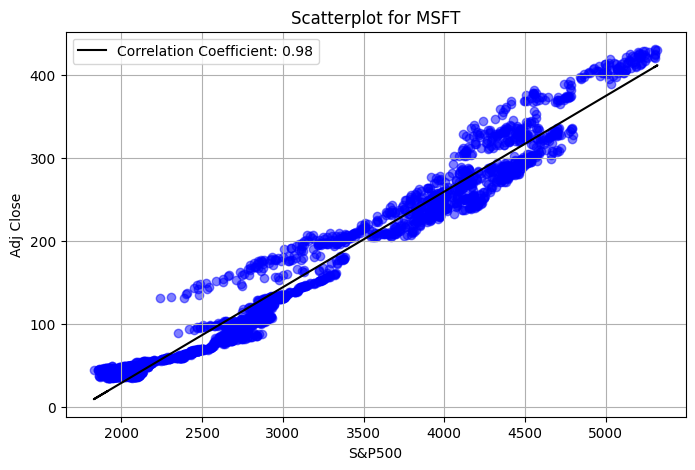

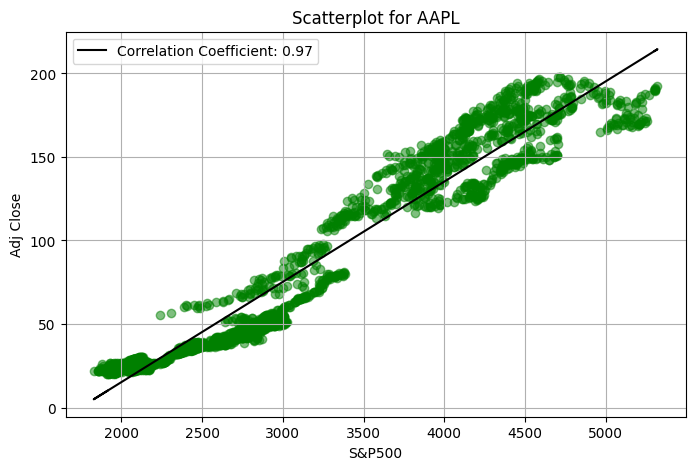

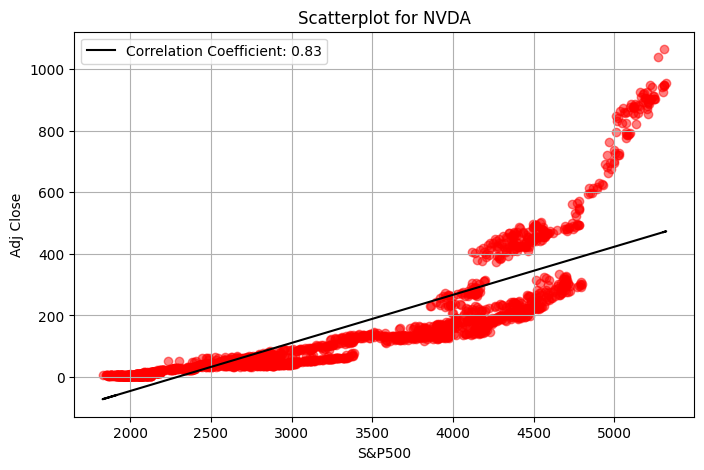

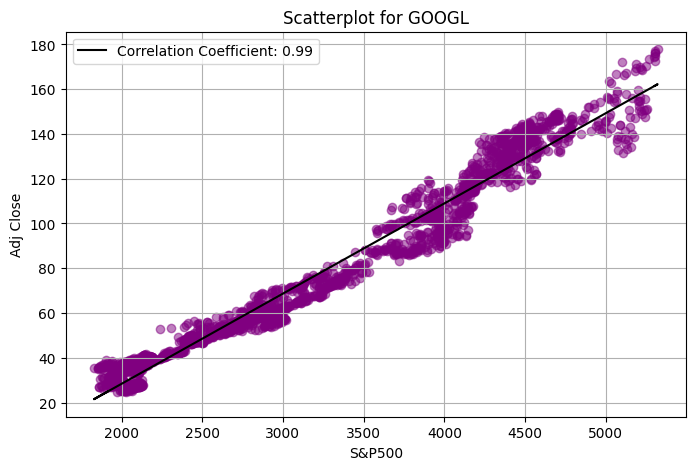

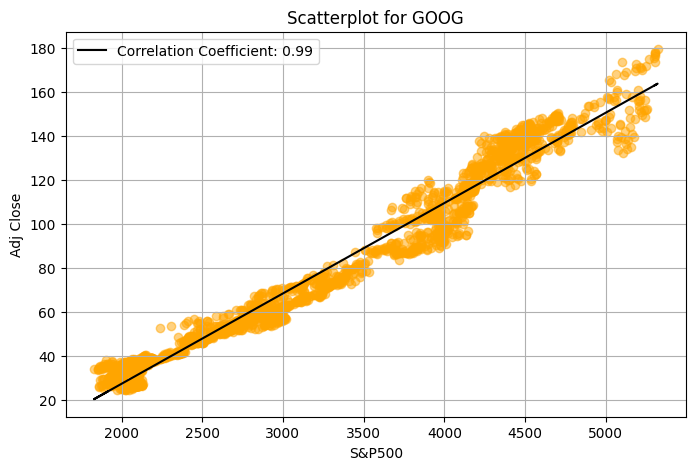

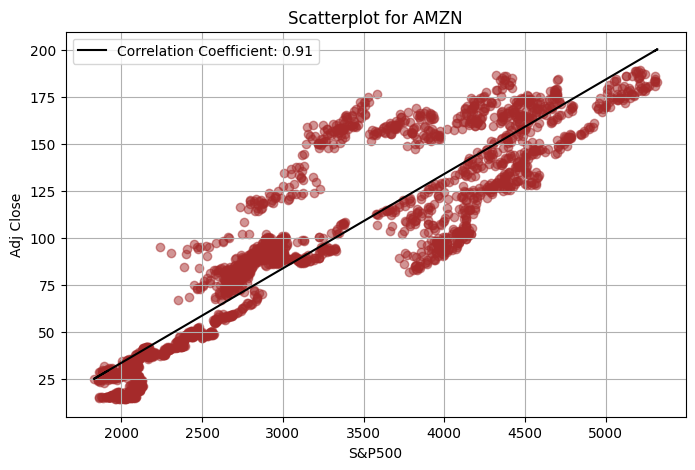

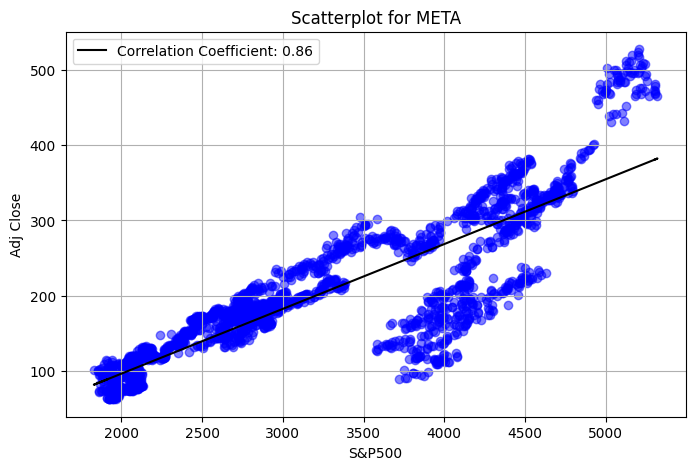

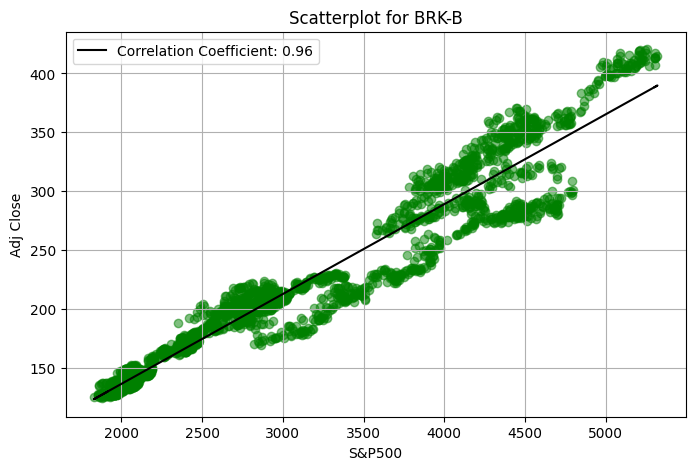

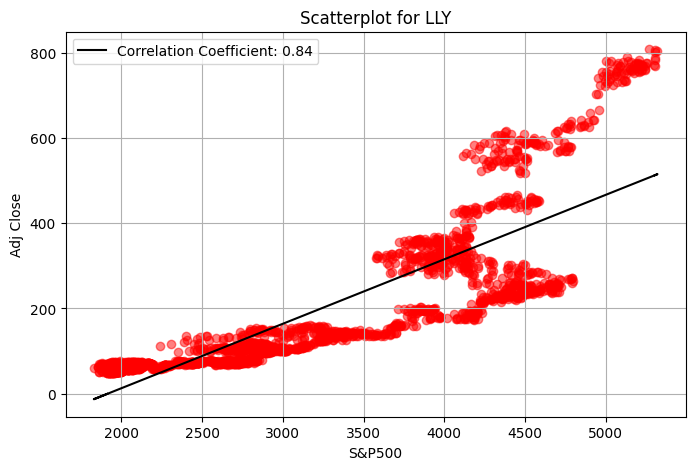

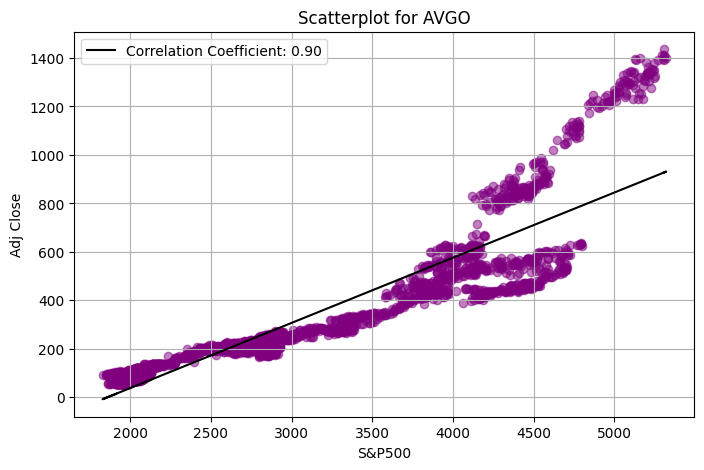

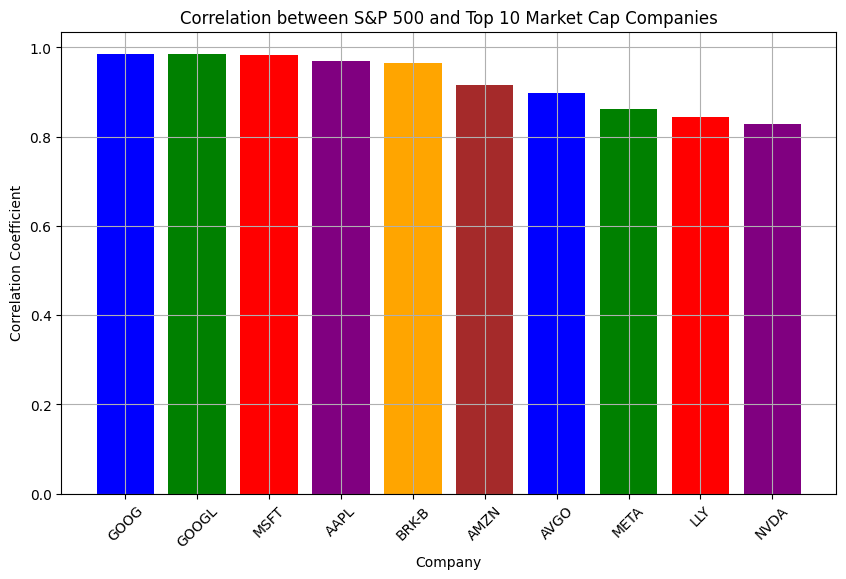

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_index.reset_index(inplace=True)

# Convert 'Date' columns to datetime objects
df_stocks['Date'] = pd.to_datetime(df_stocks['Date'])

# Merge the two datasets on the 'Date' column
merged_df = pd.merge(df_index, df_stocks, on='Date', how='inner')

# Assuming 'symbols' is defined, e.g., symbols = ['MSFT', 'AAPL']
filtered_df = merged_df[merged_df['Symbol'].isin(symbols)]

# Calculate correlation
correlation = filtered_df.groupby('Symbol')[['S&P500', 'Adj Close']].corr().iloc[0::2, -1].reset_index(level=1, drop=True)
print("Correlation between S&P 500 and top 10 market cap companies:")
print(correlation)

# Define a list of colors to cycle through
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

# Plotting scatterplots for each symbol
for index, symbol in enumerate(symbols):
    symbol_data = merged_df[merged_df['Symbol'] == symbol]
    correlation_coefficient = symbol_data['S&P500'].corr(symbol_data['Adj Close'])

    plt.figure(figsize=(8, 5))
    plt.scatter(symbol_data['S&P500'], symbol_data['Adj Close'], alpha=0.5, color=colors[index % len(colors)])

    # Add correlation line
    x = symbol_data['S&P500']
    y = symbol_data['Adj Close']
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, color='black', label=f'Correlation Coefficient: {correlation_coefficient:.2f}')  # Using black for the line

    plt.title(f'Scatterplot for {symbol}')
    plt.xlabel('S&P500')
    plt.ylabel('Adj Close')
    plt.legend()
    plt.grid(True)
    plt.show()

# Sorting the correlation dataframe in descending order
correlation_df = correlation_df.sort_values(by='Adj Close', ascending=False)

# Plotting the correlation coefficients in a bar chart
plt.figure(figsize=(10, 6))
plt.bar(correlation_df['Symbol'], correlation_df['Adj Close'], color=colors[:len(correlation_df)])
plt.xlabel('Company')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation between S&P 500 and Top 10 Market Cap Companies')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


After looking at the correlation between S&P 500 index price and the adj close price for the top 10 stocks. We try to perform stock price prediction using machine learning models like linear regression, Lasso, Ridge. We have done it in steps.

1. Data Preparation and Cleaning
2. Feature engineering
3. Data Scaling and splitting
4. Model Training and Evaluation
5. Evaluation and Visualization







**1. Data Preparation and Cleaning:**
Data frames are prepared and processed so that they can be used in the models.
*   Date Conversion : Date columns in the stock and index dataframes are converted to datetime objects for time series.
*   Since df_index data has dates starting from 2010 and df_stocks has dates starting from 2014 i have eliminated the additional dates in df_index.
*   Stock Symbol Selection: While selecting the stock symbol, i have chossen Microsoft. As it is the company with highest market cap.
*   The Dataframes stocks, index and company are merged and all the NA values are dropped





In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Convert Date to datetime and filter for a specific symbol
df_stocks['Date'] = pd.to_datetime(df_stocks['Date'])
df_index['Date'] = pd.to_datetime(df_index['Date'])
df_company['Symbol'] = df_company['Symbol'].astype(str)

# Determine the common date range
start_date = max(df_stocks['Date'].min(), df_index['Date'].min())
end_date = min(df_stocks['Date'].max(), df_index['Date'].max())

# Filter df_stocks and df_index within the overlapping date range
df_stocks_filtered = df_stocks[(df_stocks['Symbol'] == 'MSFT') & (df_stocks['Date'] >= start_date) & (df_stocks['Date'] <= end_date)]
df_index_filtered = df_index[(df_index['Date'] >= start_date) & (df_index['Date'] <= end_date)]

# Merge stocks with company data
df_merged = pd.merge(df_stocks_filtered, df_company, on='Symbol', how='left')

# Merge with the filtered S&P 500 index data
df_merged = pd.merge(df_merged, df_index_filtered, on='Date', how='left')

# Handling missing S&P500 index values (if any)
df_merged['S&P500'].fillna(method='ffill', inplace=True)

**2. Feature engineering:**

*   Moving Average and Standard deviation : The Moving averages and standard deviations over 20-day and 5-day is used to account for short-term and medium-term trends and volatility.
*   Percentage Change: It computes the daily change in stock price as percentage change, providing a measure of daily price movement.
*   Market_cap to EBITDA Ratio: The MCap_EBITDA_Ratio is calculated, which is useful to find the value of the company relative to its earnings before interest, taxes, depreciation, and amortization.
*   S&P 500 Index: This is used to capture the impact of movement in S&P 500 on stock price of the chossen company
*   Moving Average Convergence Divergence(MACD): The 26-day and 12-day Exponential moving average (EMA) are used to compute the Moving Average Convergence Divergence (MACD), an indicator to help identify price trends, measure trend momentum, often used to gauge the momentum of stock prices.
https://www.investopedia.com/terms/m/macd.asp#:~:text=What%20MACD%20Signals-,The%20MACD%20line%20is%20calculated%20by%20subtracting%20the%2026%2Dperiod,for%20buy%20or%20sell%20signals.
*   Volatility: Measures the volatility over a 30-day window as the ratio of the standard deviation to the mean of 'Adj Close', providing a normalized measure of price variability.



In [93]:
# Feature Engineering
df_merged['20_day_avg'] = df_merged['Adj Close'].rolling(window=20).mean()
df_merged['20_day_std'] = df_merged['Adj Close'].rolling(window=20).std()
df_merged['5_day_avg'] = df_merged['Adj Close'].rolling(window=5).mean()
df_merged['5_day_std'] = df_merged['Adj Close'].rolling(window=5).std()
df_merged['Return'] = df_merged['Adj Close'].pct_change()
df_merged['MCap_EBITDA_Ratio'] = df_merged['Marketcap'] / df_merged['Ebitda']
df_merged['SP500_index'] = df_merged['S&P500'].shift(1)
df_merged['26_ema'] = df_merged['Adj Close'].ewm(span=26, adjust=False).mean()
df_merged['12_ema'] = df_merged['Adj Close'].ewm(span=12, adjust=False).mean()
df_merged['MACD'] = df_merged['12_ema'] - df_merged['26_ema']
df_merged['Signal_line'] = df_merged['MACD'].ewm(span=9, adjust=False).mean()
df_merged['MACD_histogram'] = df_merged['MACD'] - df_merged['Signal_line']
df_merged['volatility'] = df_merged['Adj Close'].rolling(window=20).std() / df_merged['Adj Close'].rolling(window=20).mean()

df_merged.sort_values('Date', inplace=True)

# All NAs are dropped
df_merged.dropna(inplace=True)

# Select features and target
features = ['20_day_avg', '20_day_std','5_day_avg','5_day_std','Return', 'MCap_EBITDA_Ratio', 'Currentprice', 'SP500_index', 'MACD', 'Signal_line', 'MACD_histogram', 'volatility']
target = 'Adj Close'

Feature Analysis:

**3. Data Scaling and splitting**

**Data Scaling:** Before modeling, features are scaled using StandardScaler to ensure they contribute equally to the model's performance, important for models like Ridge and Lasso regression that are sensitive to the scale of input data.StandardScaler ensures that all variables contribute equally to the analysis by converting their values into z-scores.

**Split Data:** The data is split into training and testing sets (70% training, 30% testing). This split is essential for training the models on one set of data and testing them on unseen data to evaluate their predictiveness.

In [95]:
# Scaling the full dataset for model evaluation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_merged[features])
y = df_merged[target]

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=False, random_state=42)

**4. Model Training and Evaluation:**
I have used Linear Regression, Lasso Regression, and Ridge Regression models.

**Linear Regression:** Linear Regression is fundamental statistical model for modeling the relationship between a dependent variable and one or more independent variables by fitting a linear equation to observed data.I have used Linear Regression to predict the 'Adj Close' price of a stock based on various technical indicators and financial ratios. The model assumes a linear relationship between the features (like moving averages, MACD values) and the stock price.


**Lasso Regression:** Lasso (Least Absolute Shrinkage and Selection Operator) Regression is a type of linear regression that uses regularization. Lasso Regression ensures no single factor feature in data shouts too loudly. It does this by applying penalty to each feature based on its influence on prediction. The bigger the influence, the bigger the penalty. If a feature's influence is too small, Lasso drops it to zero or ignores that feature completely. This helps in simpliying your model by using only the important features, and it prevents the model from overfitting. I have used alpha value of 0.1, suggesting moderate regularization. Since there are many features it can identify and eliminate non-informative features, simplifying the model and potentially improving generalization performance.

**Ridge Regression:** Ridge Regression is like linear regression, designed to make predictions more reliable. Ridge uses a technique where the penalty is based on the square of each features magnitude. This doesn't allow any of the feature to go to zero (like in Lasso), but it does shrink them, especially the larger ones. All factors stay in the model but their influence is controlled, which avoids fitting too closely to the noisy or less important features of  data (overfitting). Ridge Regression is applied with an alpha value of 1.0, which controls the regularization strength. This model is particularly useful when the number of predictor variables in a regression model exceeds the number of observations.

In [96]:
# Initialize and train models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(alpha=0.1, max_iter=10000),
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': GridSearchCV(RandomForestRegressor(random_state=42), param_grid={'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}, cv=5, n_jobs=-1),
    'Gradient Boosting': GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid={'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}, cv=5, n_jobs=-1),
    'Bagging': GridSearchCV(BaggingRegressor(base_estimator=DecisionTreeRegressor(), random_state=42), param_grid={'n_estimators': [50, 100, 200]}, cv=5, n_jobs=-1),
    # 'K-Nearest Neighbors': GridSearchCV(KNeighborsRegressor(), param_grid={'n_neighbors': [3, 5, 7, 9]}, cv=5, n_jobs=-1)
}

**5. Evaluation and Visualization:**

**Evaluation:** After making predictions using the model i calculate key metrics like MSE, MAE, RMSE, and R square to evaluate each model's performance.

**Plotting Results:** It plots the actual vs. predicted stock prices to visually assess how well the models are performing.

**Feature Importance:** Coefficients assigned to features of each model can provide insights into how each feature impacts the model's predictions.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


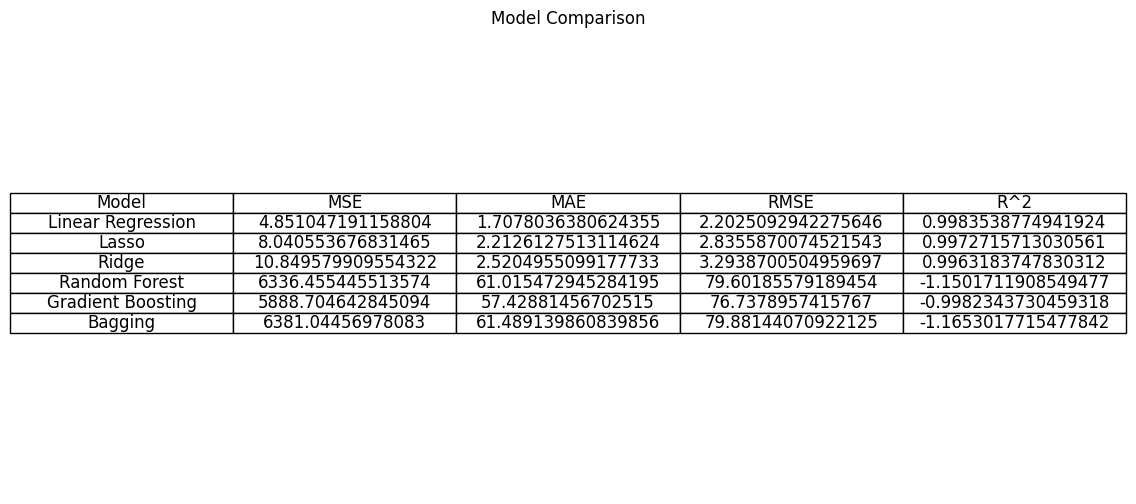

Linear Regression - MSE: 4.8510, MAE: 1.7078, RMSE: 2.2025, R^2: 0.9984
Linear Regression Latest Prediction for next day: Predicted: 429.97, Actual: 430.16


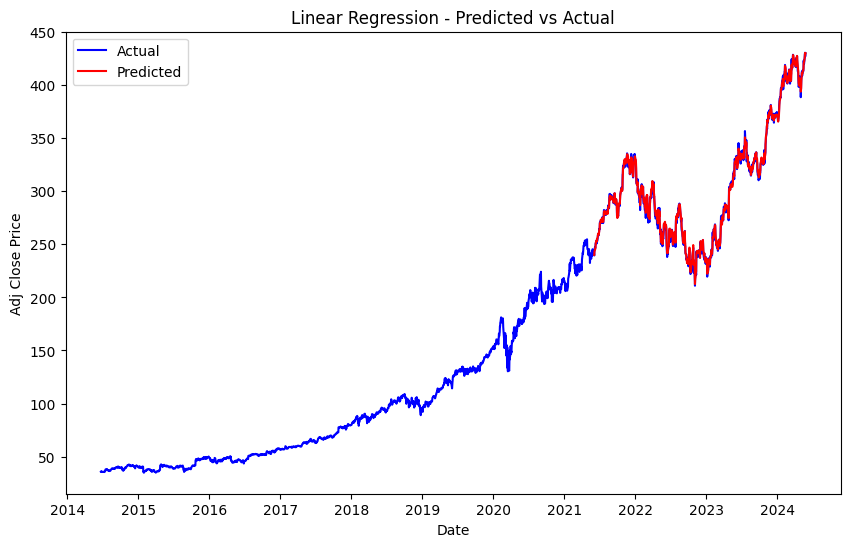

Feature importances for Linear Regression:
                    Coefficient
20_day_avg         1.949011e+02
5_day_avg         -8.425355e+01
MACD_histogram     7.492532e+00
MACD               3.821931e+00
Signal_line        1.535369e+00
Return             7.942355e-01
SP500_index       -7.697443e-02
20_day_std        -4.822204e-02
5_day_std         -3.564401e-02
volatility        -1.912720e-02
Currentprice       1.293188e-12
MCap_EBITDA_Ratio -1.111999e-12
Lasso - MSE: 8.0406, MAE: 2.2126, RMSE: 2.8356, R^2: 0.9973
Lasso Latest Prediction for next day: Predicted: 429.62, Actual: 430.16


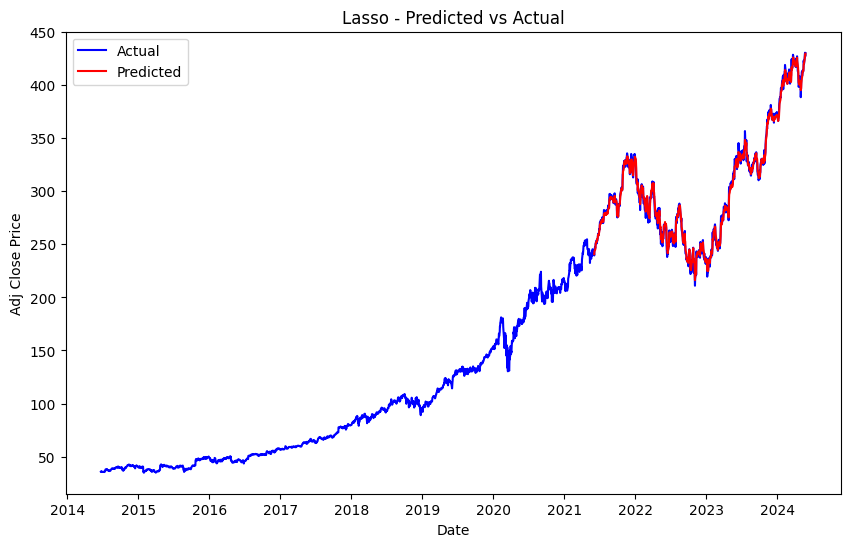

Feature importances for Lasso:
                   Coefficient
20_day_avg          109.781583
MACD_histogram        4.358610
MACD                  2.780092
Return                0.882448
5_day_avg             0.578317
SP500_index           0.454769
20_day_std            0.000000
5_day_std             0.000000
MCap_EBITDA_Ratio     0.000000
Currentprice          0.000000
Signal_line           0.000000
volatility           -0.000000
Ridge - MSE: 10.8496, MAE: 2.5205, RMSE: 3.2939, R^2: 0.9963
Ridge Latest Prediction for next day: Predicted: 430.55, Actual: 430.16


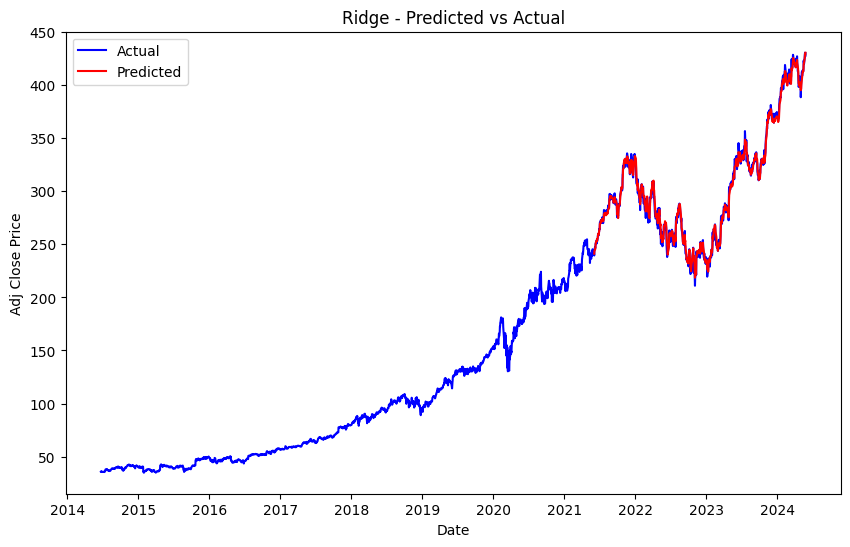

Feature importances for Ridge:
                   Coefficient
20_day_avg           57.882586
5_day_avg            50.565499
MACD_histogram        3.167334
SP500_index           2.035418
MACD                  1.232867
Return                1.085007
20_day_std            0.573110
5_day_std             0.387638
Signal_line           0.239246
volatility           -0.220580
MCap_EBITDA_Ratio     0.000000
Currentprice          0.000000
Random Forest - MSE: 6336.4554, MAE: 61.0155, RMSE: 79.6019, R^2: -1.1502
Random Forest Latest Prediction for next day: Predicted: 250.80, Actual: 430.16


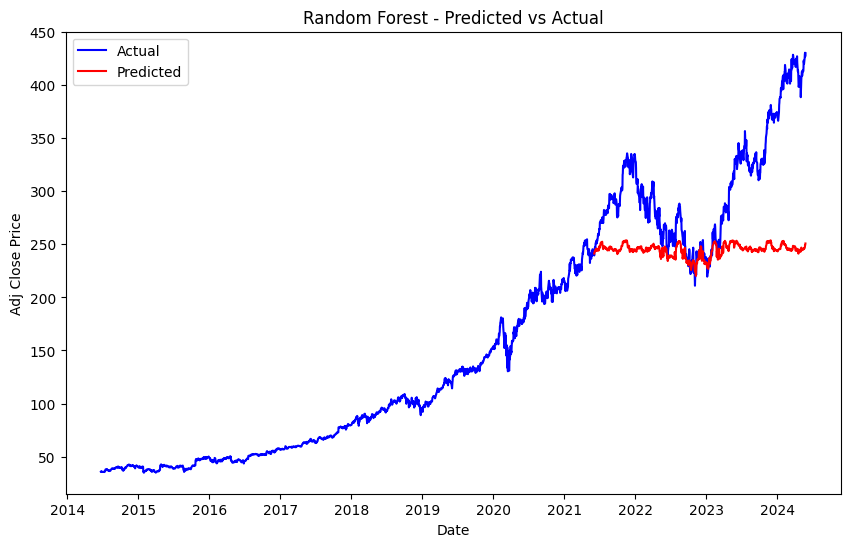

Feature importances for Random Forest:
                   Importance
5_day_avg            0.805748
20_day_avg           0.192089
SP500_index          0.001123
MACD_histogram       0.000280
Return               0.000248
MACD                 0.000176
5_day_std            0.000098
20_day_std           0.000091
volatility           0.000075
Signal_line          0.000073
MCap_EBITDA_Ratio    0.000000
Currentprice         0.000000
Gradient Boosting - MSE: 5888.7046, MAE: 57.4288, RMSE: 76.7379, R^2: -0.9982
Gradient Boosting Latest Prediction for next day: Predicted: 253.80, Actual: 430.16


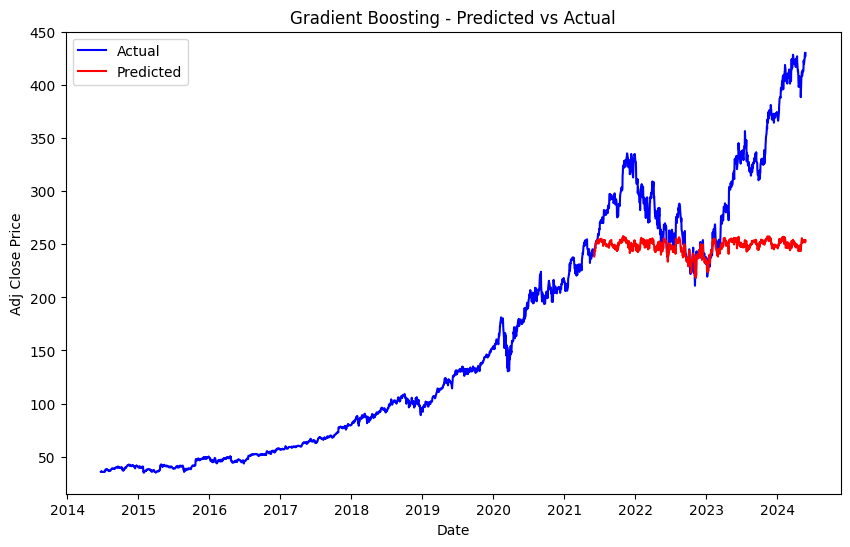

Feature importances for Gradient Boosting:
                   Importance
5_day_avg            0.523522
20_day_avg           0.471821
SP500_index          0.003825
Return               0.000412
MACD_histogram       0.000230
5_day_std            0.000079
Signal_line          0.000035
MACD                 0.000032
volatility           0.000025
20_day_std           0.000019
MCap_EBITDA_Ratio    0.000000
Currentprice         0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging - MSE: 6381.0446, MAE: 61.4891, RMSE: 79.8814, R^2: -1.1653
Bagging Latest Prediction for next day: Predicted: 250.76, Actual: 430.16


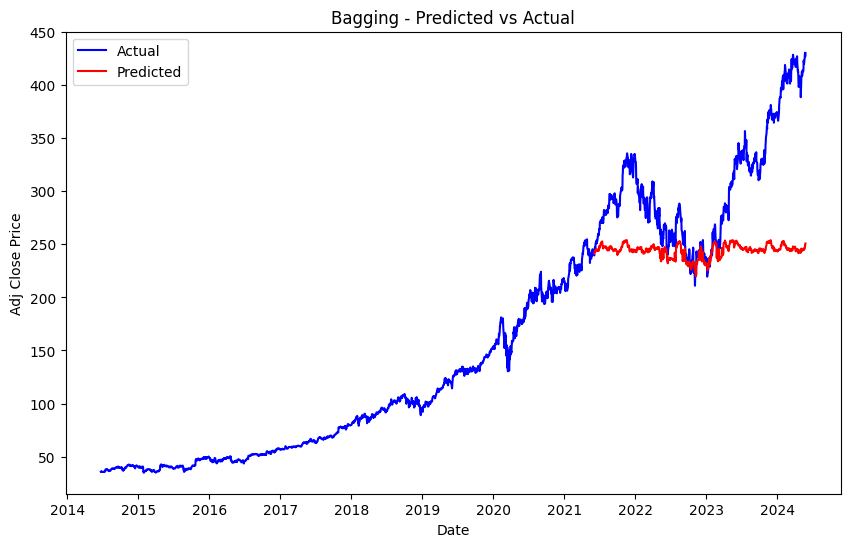

Feature importances for Bagging:
                   Importance
5_day_avg            0.779951
20_day_avg           0.217732
SP500_index          0.001242
MACD_histogram       0.000284
Return               0.000247
MACD                 0.000203
5_day_std            0.000097
20_day_std           0.000087
volatility           0.000083
Signal_line          0.000075
MCap_EBITDA_Ratio    0.000000
Currentprice         0.000000


In [97]:
# Prepare DataFrame for storing predictions
df_predictions = df_merged.iloc[len(X_train):].copy()

# DataFrame for storing evaluation metrics
metrics = pd.DataFrame(columns=['Model', 'MSE', 'MAE', 'RMSE', 'R^2'])

# Fit models and save predictions
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    df_predictions[name + ' Predictions'] = predictions

    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    metrics = pd.concat([metrics, pd.DataFrame({'Model': [name], 'MSE': [mse], 'MAE': [mae], 'RMSE': [rmse], 'R^2': [r2]})], ignore_index=True)

# Ensure correct merging by checking column names
prediction_columns = [name + ' Predictions' for name in models.keys()]
df_merged_final = pd.merge(df_merged, df_predictions[['Date'] + prediction_columns], on='Date', how='left')

# Export to CSV
df_merged_final.to_csv('stock_predictions.csv', index=False)
metrics.to_csv('model_metrics.csv', index=False)

# Plot the comparative table
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=metrics.values, colLabels=metrics.columns, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

plt.title('Model Comparison')
plt.show()

# Fit models and print outcomes
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"{name} - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R^2: {r2:.4f}")
    print(f"{name} Latest Prediction for next day: Predicted: {predictions[-1]:.2f}, Actual: {y_test.iloc[-1]:.2f}")

    # Plotting predictions vs actual values
    plt.figure(figsize=(10, 6))
    plt.plot(df_merged['Date'], df_merged['Adj Close'], label='Actual', color='blue')
    plt.plot(df_merged.iloc[-len(predictions):]['Date'], predictions, label='Predicted', color='red')
    plt.title(f"{name} - Predicted vs Actual")
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price')
    plt.legend()
    plt.show()

    if hasattr(model, 'coef_'):
        # For models with coefficients
        print(f"Feature importances for {name}:")
        feature_importance = pd.DataFrame(model.coef_, index=features, columns=['Coefficient'])
        print(feature_importance.sort_values(by='Coefficient', key=abs, ascending=False))
    elif hasattr(model, 'best_estimator_') and hasattr(model.best_estimator_, 'feature_importances_'):
        # For tree-based models
        print(f"Feature importances for {name}:")
        feature_importance = pd.DataFrame(model.best_estimator_.feature_importances_, index=features, columns=['Importance'])
        print(feature_importance.sort_values(by='Importance', ascending=False))
    elif name == 'Bagging':
        # Calculate feature importances for Bagging
        feature_importances = np.mean([tree.feature_importances_ for tree in model.best_estimator_.estimators_], axis=0)
        print(f"Feature importances for {name}:")
        feature_importance = pd.DataFrame(feature_importances, index=features, columns=['Importance'])
        print(feature_importance.sort_values(by='Importance', ascending=False))